In [108]:
import numpy as np
from scipy.ndimage import convolve
import cv2
from matplotlib import pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()

def generate_octave(init_level, escalas, sigma):
    octave = [init_level]
    k = 2 ** (1/escalas)
    # Generar el kernel gaussiano
    kernel = gaussian_filter(k * sigma)
    for _ in range(escalas):
        # Convolucionar el nivel anterior con el kernel gaussiano
        next_level = convolve(octave[-1], kernel, mode='nearest')
        octave.append(next_level)
    return octave

def generate_gaussian_pyramid(image, octaves, scales, sigma):
    pyramid = []
    for _ in range(octaves):
        octave = generate_octave(image, scales, sigma)
        pyramid.append(octave)
        # La siguiente imagen de la pirámide es la imagen de nivel 3 de la octava anterior
        image = octave[-3]
        # Reducir la resolución para la siguiente iteración
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid

def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = [octave[i] - octave[i+1] for i in range(len(octave) - 1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid

def find_keypoints(dog_pyramid, threshold=0.074):
    keypoints = []
    
    for octave_index, octave in enumerate(dog_pyramid):
        for scale_index, (dog_level1, dog_level2) in enumerate(zip(octave[:-1], octave[1:])):
            # Encontrar los puntos clave usando el detector de esquinas Harris
            harris_response = cv2.cornerHarris(dog_level1, blockSize=5, ksize=3, k=0.05)
            
            # Filtrar los puntos clave por umbral
            keypoints_indices = np.argwhere(harris_response > threshold)
            
            # Agregar los puntos clave a la lista
            for keypoint_index in keypoints_indices:
                y, x = keypoint_index
                keypoints.append((x * (2 ** octave_index), y * (2 ** octave_index), scale_index + 1))
    
    return keypoints

def calculate_gradient_orientation(image, sigma):
    smoothed_image = cv2.GaussianBlur(image, (0, 0), sigma)
    dx = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = np.arctan2(dy, dx)
    return magnitude, orientation

def assign_orientation(keypoints, img_gray):
    oriented_keypoints = []
    max_orientations = []
    histogram = np.zeros(36)

    for x, y, scale in keypoints:
        # Definir una región alrededor del punto clave
        radius = int(3 * scale)
        region = img_gray[max(0, int(y) - radius):int(y) + radius + 1,
                          max(0, int(x) - radius):int(x) + radius + 1]

        # Calcular el histograma de orientación
        magnitude, orientation = calculate_gradient_orientation(region, sigma=1.5*scale)

        # Crear un histograma ponderado por la magnitud del gradiente
        histogram, bin_edges = np.histogram(orientation, bins=36, range=(-np.pi, np.pi), weights=magnitude)

        # Encontrar la orientación dominante en el histograma (valor máximo)
        dominant_orientation = bin_edges[np.argmax(histogram)]

        # Añadir el punto clave con la orientación asignada a la lista
        oriented_keypoints.append((x, y, scale, dominant_orientation))
        
    bin_edges = np.linspace(0, 360, 37)
    # plt.figure()
    # plt.bar(bin_edges[:-1], histogram, width=10, align='edge', color='blue', edgecolor='black')
    # plt.title('Histograma acumulado de orientación')
    # plt.xlabel('Intervalos de 10 grados')
    # plt.ylabel('Magnitud acumulada')
    # plt.show()
    return oriented_keypoints

def sift(img, octavas, escalas, sigma):
    img = np.array(img)
    img = rgb2gray(img)
    gaussian_pyramid = generate_gaussian_pyramid(img, octavas, escalas, sigma)
    dog_pyramid = generate_dog_pyramid(gaussian_pyramid)
    keypoints = find_keypoints(dog_pyramid)
    oriented_keypoints = assign_orientation(keypoints, img)
    sift = cv2.SIFT_create()
    keypoints_for_sift = [cv2.KeyPoint(float(x), float(y), float(scale)) for x, y, scale, _ in oriented_keypoints]
    _, descriptors = sift.compute(img, keypoints_for_sift)
    return keypoints, descriptors


Prueba 1 terminada
Prueba 2 terminada


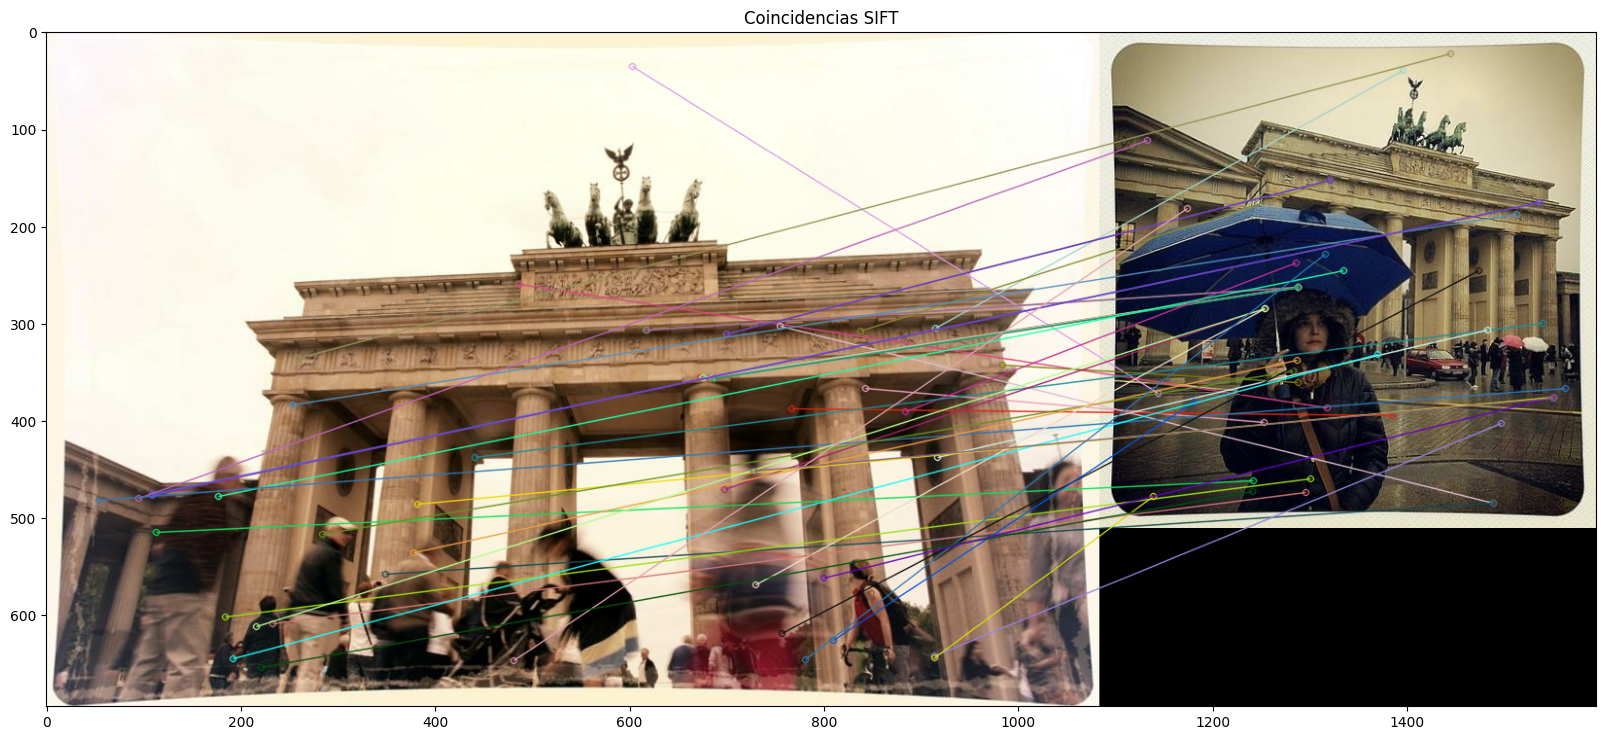

In [117]:
imagen1 = cv2.imread('prueba1.jpg')
imagen2 = cv2.imread('prueba3.jpg')
escalas = 5  
sigma = 1.6
octavas = 4 

keypoints1, descriptores1 = sift(imagen1, octavas, escalas, sigma)
print("Prueba 1 terminada")
keypoints2, descriptores2 = sift(imagen2, octavas, escalas, sigma)
print("Prueba 2 terminada")


bf = cv2.BFMatcher()

# Realizar la coincidencia de descriptores
coincidencias = bf.knnMatch(descriptores1, descriptores2, k=2)

# Aplicar el filtro de Ratio Test
buenas_coincidencias = []
for m, n in coincidencias:
    if m.distance < 0.64* n.distance:
        buenas_coincidencias.append(m)
        
imagen1_rgb = cv2.cvtColor(imagen1, cv2.COLOR_BGR2RGB)
imagen2_rgb = cv2.cvtColor(imagen2, cv2.COLOR_BGR2RGB)

# Convert keypoints to list of cv2.KeyPoint objects
keypoints1_list = [cv2.KeyPoint(float(x), float(y), float(scale)) for x, y, scale in keypoints1]
keypoints2_list = [cv2.KeyPoint(float(x), float(y), float(scale)) for x, y, scale in keypoints2]

resultado = cv2.drawMatches(imagen1_rgb, keypoints1_list, imagen2_rgb, keypoints2_list, buenas_coincidencias, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow('Coincidencias SIFT', resultado)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(20, 20))
plt.imshow(resultado)
plt.title('Coincidencias SIFT')
plt.show()

